In [ ]:
import tensorflow as tf
import gym
import numpy as np
from stable_baselines import DQN
from copy import deepcopy
import math
from gym.spaces import Discrete, Dict, Box
from gym import spaces
from random import seed
import random 
from gym import Env
from datetime import datetime
import sys
import time
import pickle
import stable_baselines
import sklearn
import numpy
from sklearn import tree , svm 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB , CategoricalNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import accuracy_score,balanced_accuracy_score
from itertools import product
from sklearn.utils import resample
from sklearn.model_selection import KFold , RepeatedKFold
from sklearn.metrics import f1_score
from sklearn import impute
import statistics
from scipy import stats
from copy import deepcopy
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from math import ceil
import copy
import sys
from sklearn.metrics import jaccard_score
import time
import multiprocessing
from pymoo.algorithms.nsga2 import calc_crowding_distance
sys.path.append('lib/')
import subprocess
import logging
from sklearn.utils import shuffle
import csv
from csv import reader
import os
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score, accuracy_score


In [ ]:

class StoreAndTerminateWrapper(gym.Wrapper):
  ''''
  :param env: (gym.Env) Gym environment that will be wrapped
  :param max_steps: (int) Max number of steps per episode
  '''
  def __init__(self, env):
    # Call the parent constructor, so we can access self.env later
    super(StoreAndTerminateWrapper, self).__init__(env)
    self.max_steps = 200
    # Counter of steps per episode
    self.current_step = 0
    self.mem = []
    self.TotalReward = 0.0 
    self.env = env
    self.first_state = 0
    self.first_obs = 0
    self.prev_obs = 0 
    self.states_list = []
    self.info = {}
  
  def reset(self):
    """
    Reset the environment 
    """
    # Reset the counter
    self.current_step = 0
    obs =self.env.reset()
    self.TotalReward = 0.0
    self.first_obs = obs
    return obs

  def step(self, action):
    """
    In this function we store the initial state as well as the memory of the agent
    :param action: ([float] or int) Action taken by the agent
    :return: (np.ndarray, float, bool, dict) observation, reward, is the episode over?, additional informations
    """
    if self.current_step == 0: #store initial state
      self.prev_obs = self.first_obs
      self.first_state = deepcopy(self.env)
      self.states_list.append(self.first_state)
    # print("t",self.env.state[0],"reward",self.TotalReward)
    # if self.env.state[0]==-1.2:
    #   print("-1.2")
    #   obs = self.reset()
    #   reward = -200
    #   done = True
    #   return obs, reward, done, False
    self.current_step += 1
    obs, reward, done, info = self.env.step(action)
    self.TotalReward += reward
    self.mem.append(tuple((self.prev_obs,action)))
    self.prev_obs = obs
    if self.current_step >= self.max_steps:
      done = True
      # Update the info dict to signal that the limit was exceeded
    if obs[0]<=-1.2:
      done = True
      reward = -201 - self.TotalReward
      self.TotalReward =-200
      # print("fff",reward)
    if done:
      self.mem.append(tuple(('done',self.TotalReward)))
    self.info['mem'] = self.mem
    self.info['state'] = self.states_list
    # self.mem.append(tuple(obs,action))
    return obs, reward, done, info

  def set_state(self, state):
    """
    :param state: initial state of the episode
    :return: environment is updated and observations is returned
    """
    self.env = deepcopy(state)
    obs = np.array(list(self.env.unwrapped.state))
    self.current_step = 0
    self.TotalReward = 0.0
    self.first_obs = obs
    return obs


def abstract_state_general(model,state1,d):
  if type(state1) == str:
    if state1 == 'done':
      return 'end'
  q_values = model.step_model.step([state1])
  return tuple([ceil(q_value/d) for q_value in q_values[1][0]])

def Abstract_classes(ep,abstraction_d,model):
  d=abstraction_d
  abs_states1=[]
  for episode in ep:
    for state,action in episode:
      abs_st = abstract_state_general(model,state,d)
      if abs_st == 'end':
        continue
      abs_states1.append(abs_st)
  unique1=list(set(abs_states1))
  uni1 = np.array(unique1)
  a=len(abs_states1)
  b=len(set(abs_states1))
  print("abstract states:",b)
  print("Concrete states",a)
  print("ratio",b/a)
  return unique1,uni1

def ML_first_representation_func_based(Abs_d,functional_func,reward_func,model,input_episodes,unique1):
  """
  TO-DO : fix epsilon and threshold
  """
  d = Abs_d
  data1_x_b=[]
  data1_y_b= [] 
  data1_y_f_b = []
  for i, episode in enumerate(input_episodes):
    record = np.zeros(len(unique1))
    temp_flag = False
    for state, action in episode:
      ab = abstract_state_general(model,state,d)
      if ab == 'end':
        assert not temp_flag, f'Episode data problem, two terminations in one episode. Episode number{i}'
        temp_flag = True
        # print(action)
        # print(functional_func(episode))
        if functional_func(episode):
          data1_y_f_b.append(1)
        else:
          data1_y_f_b.append(0)
        if reward_func(episode):
          data1_y_b.append(1)
        else:
          data1_y_b.append(0)
        # print("end\n\n\n")
        # print(len(data1_y_b),"len(input_episodes)",len(input_episodes))
        continue
        # print(state[0])
      ind = unique1.index(ab)
      record[ind] = 1
      # print(state, action)
      assert len(data1_y_b)<len(input_episodes), "assert"
      # if you want the frequency go with the next line 
      # record[ind] += 1
    data1_x_b.append(record)

  return data1_x_b, data1_y_b, data1_y_f_b

def report(model2,x_train, y_train,x_test, y_test):
  print("********************** reporting the result of the model **************************")
  print('The score for train data is {0}'.format(model2.score(x_train,y_train)))
  print('The score for test data is {0}'.format(model2.score(x_test,y_test)))


  predictions_train = model2.predict(x_train)
  predictions_test = model2.predict(x_test)

  print("\n\n--------------------------------------recall---------------------------------")

  print('the test recall for the class yes is {0}'.format(metrics.recall_score(y_test,predictions_test, pos_label=1)))
  print('the test recall for the class no is {0}'.format(metrics.recall_score(y_test,predictions_test, pos_label=0)))

  print('the training recall for the class yes is {0}'.format(metrics.recall_score(y_train,predictions_train, pos_label=1)))
  print('the training recall for the class no is {0}'.format(metrics.recall_score(y_train,predictions_train, pos_label=0)))


  print("\n\n--------------------------------------precision------------------------------")


  print('the test precision for the class yes is {0}'.format(metrics.precision_score(y_test,predictions_test, pos_label=1)))
  print('the test precision for the class no is {0}'.format(metrics.precision_score(y_test,predictions_test, pos_label=0)))

  print('the training precision for the class yes is {0}'.format(metrics.precision_score(y_train,predictions_train, pos_label=1)))
  print('the training precision for the class no is {0}'.format(metrics.precision_score(y_train,predictions_train, pos_label=0)))

  print("\n\n")
  print(classification_report(y_test, predictions_test, target_names=['NO ','yes']))

  tn, fp, fn, tp = confusion_matrix(y_test, predictions_test).ravel()
  specificity = tn / (tn+fp)
  print("\n\nspecifity :",specificity)
  print("\n\n--------------------------------------confusion----------------------------")
  CM = metrics.confusion_matrix(y_test, predictions_test)
  print("The confusion Matrix:")
  print(CM)
  print('the accuracy score in {0}\n\n'.format(accuracy_score(y_test, predictions_test)))
  print("********************** plotting the confusion matrix & ROC curve **************************")
  plot_confusion_matrix(model2, x_test, y_test)
  metrics.plot_roc_curve(model2, x_test, y_test) 
  plt.show()

# write function for load


def random_test_2(model, env, Num):
  # start= len(info['mem'])
  obs=env.reset()
  counter = 1
  episode_reward = 0.0
  for i in range(Num):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    episode_reward += reward
    if done:
      counter += 1
      end = i
      episode_reward = 0.0
      obs = env.reset()
  iter = deepcopy(counter)
  u=1
  while iter>1:
    if env.info['mem'][-u][0]=='done':
      lastpoint = -u
      iter -= 1
    u+=1
  fin =Num - end
  start = -Num -counter
  randomtest = env.info['mem'][lastpoint:-fin]
  ran_state = env.info['state'][(-counter+1):-1]
  return randomtest , ran_state

def fix_testing(testing_episodes,testing_states,Env2):
  buffer =[] 
  episodes_set = []
  j=0
  for i in range(len(testing_episodes)):
    if testing_episodes[i][0] == 'done':
      if i == 0:
        continue
      buffer.append(testing_episodes[i])
      episodes_set.append(buffer)
      buffer=[]
    else:
      buffer.append(testing_episodes[i])
      # np.array(mtc_wrapped.set_state(qq[0]),dtype="float32")
  if not (episodes_set[0][0][0]==np.array(Env2.set_state(testing_states[0]),dtype="float32")).all():
    del testing_states[0]
  if not (episodes_set[0][0][0]==np.array(Env2.set_state(testing_states[0]),dtype="float32")).all():
    assert False, 'problem in starting states'
  if len(episodes_set)!=len(testing_states):
    del testing_states[-1]
  if len(episodes_set)!=len(testing_states):
    assert False, 'problem in data prepration'
  return episodes_set , testing_states

def is_functional_fault(episode):
  epsilon = 0.1
  env = mtc_wrapped
  reward = episode[-1][1]
  last_state = episode[-2][0][0]
  if last_state<(env.low[0]+epsilon) and reward == -200:
    return True
  else:
    return False


def is_reward_fault(episode):
  RF_threshold = -180
  reward = episode[-1][1]
  # print(len(episode))
  if reward<RF_threshold and len(episode)>200:
    return True
  else:
    return False

def is_functional_fault_last_state(last_step,done_step):
  epsilon = 0.1
  env = mtc_wrapped
  assert done_step[0]=='done', "Wrong input!"
  reward = done_step[1]
  last_state = last_step[0][0]
  if last_state<(env.low[0]+epsilon) and reward == -200:
    return True
  else:
    return False


def is_reward_fault_last_state(last_step,done_step):
  RF_threshold = -180
  assert done_step[0]=='done', "Wrong input!"
  reward = done_step[1]
  last_state = last_step[0][0]
  # print(len(episode))
  if reward<RF_threshold and not is_functional_fault_last_state(last_step,done_step):
    return True
  else:
    return False

def load_p(name):
  with open(f'/content/drive/MyDrive/MC/{name}.pickle', 'rb') as file2:
    to_what = pickle.load(file2)
  return to_what
def local_load_p(name):
  with open(f'c:/Users/Student/Desktop/Data/{name}', 'rb') as file2:
    to_what = pickle.load(file2)
  return to_what



# plot functions

In [ ]:
def translator(episode,model, d, unique5):
  """
  thid function takes the concrete episodes and returns the encoded episodes 
  based on the presence and absence of the individuals  
  :param 'episode': input episode
  :param 'model': RL model
  :param 'd': abstraction level = 1
  :param 'unique5': abstract classes 
  :return: encoded episodse based on the presence and absence

  """
  d=d
  record = np.zeros(len(unique5))
  for state, action in episode:
    ab = abstract_state_general(model,state,d)
    if ab == 'end':
      continue
    if ab in unique5:
      ind = unique5.index(ab)
      record[ind] = 1
  return [record]

def episode_player(episodes,d, abs_classes, model, monitor) -> list:
  ''' This function replays the episodes and returns the risk of each step in each episode
  :param 'episodes': input episodes
  :param 'd': abstraction level 
  :param 'abs_classes': abstract classes
  :param 'model': RL model
  :param 'monitor': ML model
  :return: risk of each step in each episode
  
  '''
  episodes_risk=[]
  for episode in episodes:
    risk_array=[]
    for step in range(len(episode)-1):
      monitoring_data = translator(episode[:step],model,d,abs_classes)
      Risk = monitor.predict_proba(monitoring_data)
      risk_array.append(Risk[0][1])
    episodes_risk.append(risk_array)
  return episodes_risk

def single_episode_player(episode,d, abs_classes, model, monitor) -> list:
  ''' This function replays one episodes and returns the risk of each step in episode
  :param 'episode': input episode
  :param 'd': abstraction level
  :param 'abs_classes': abstract classes
  :param 'model': RL model
  :param 'monitor': ML model
  :return: risk of each step in episode
  '''
  risk_array=[]
  for step in range(len(episode)-1):
    monitoring_data = translator(episode[:step],model,d,abs_classes)
    Risk = monitor.predict_proba(monitoring_data)
    risk_array.append(Risk[0][1])
  return risk_array

def line_plot(data):
    plt.figure(figsize=(20, 6))
    for i in range(len(data)): 
        plt.plot( [i for i in range(len(data[i]))], data[i], label = f"Episode {i}")
    # plt.plot(y, x, label = "line 2")
        
    plt.legend()
    plt.show()

def plot_positions(episodes):
    plt.figure(figsize=(20, 6))
    
    for i in range(len(episodes)):
        position =[]
        position_arr =[]
        for j in range(len(episodes[i])-1):
            position.append(episodes[i][j][0][0])
        position_arr.append(position)
        plt.plot([i for i in range(len(position))], position, label = f"Episode {i}")
        
    plt.legend()
    plt.show()

def plot_velocity(episodes):
    plt.figure(figsize=(20, 6))
    
    for i in range(len(episodes)):
        velocity =[]
        velocity_arr =[]
        for j in range(len(episodes[i])-1):
            velocity.append(episodes[i][j][0][1])
        velocity_arr.append(velocity)
        plt.plot([i for i in range(len(velocity))], velocity, label = f"Episode {i}")
        
    plt.legend()
    plt.show()

def position_extractor(episode):
    position =[]
    for i in range(len(episode)-1):
        position.append(episode[i][0][0])
    return position
    
def velocity_extractor(episode):
    velocity =[]
    for i in range(len(episode)-1):
        velocity.append(episode[i][0][1])
    return velocity


def Plot_all(data, params,save=False,show=True,data_chunk=0,path='Plots/v2'):
    '''plot risk and position snd velocity in one figure with 3 subplots
    '''
    d,unique1,model,RF_FF_1rep = params
    fig, axs = plt.subplots(3,figsize=(20, 18))
    for i in range(len(data)):
        axs[0].plot([i for i in range(len(data[i])-1)], single_episode_player(data[i],d,unique1,model,RF_FF_1rep), label = f"Episode {i}")
        axs[1].plot([i for i in range(len(data[i])-1)], position_extractor(data[i]), label = f"Episode {i}")
        axs[2].plot([i for i in range(len(data[i])-1)], velocity_extractor(data[i]), label = f"Episode {i}")
    axs[0].legend()
    axs[0].set_title('Risk')
    axs[1].set_title('Position')
    axs[2].set_title('Velocity')
    axs[1].legend()
    axs[2].legend()
    axs[0].set_ylim(-0.1,1.1)
    current_time = datetime.now()
    ID = current_time.strftime("%Y%m%d%H%M%S")
    if save:
        fig.savefig(f'{path}/RPV_C{data_chunk}_{ID}.png')
    plt.close()
    


# Load model

In [ ]:
#Address of the trained RL model 
Dataset_path = "path to dataset"

Drive_model  =f"{Dataset_path}/dqn-4-1-6-89946.zip"

mtc = gym.make('MountainCar-v0')
mtc_wrapped = StoreAndTerminateWrapper(mtc)
model = DQN('MlpPolicy',env=mtc_wrapped, verbose=1)
model = model.load(Drive_model)



# Training data generation

In [6]:
RT,RTS = random_test_2(model,mtc_wrapped,300_000)
FRT,FRTS = fix_testing(RT,RTS,mtc_wrapped)
#save FRT and FRTS as pickle
training_size = 2200
assert len(FRT) >= training_size
with open(f'{Dataset_path}/Random_episodes/FRT_training.pickle', 'wb') as file2:
    pickle.dump(FRT[:training_size], file2)
with open(f'{Dataset_path}/Random_episodes/FRTS_training.pickle', 'wb') as file2:
    pickle.dump(FRTS[:training_size], file2)

RF=0
FF=0
Buff_reward = 0
Buff_len = 0
for test_episode in FRT:
    Buff_reward += test_episode[-1][1]
    Buff_len += (len(test_episode)-1)
    if is_functional_fault(test_episode):
        FF+=1
    if is_reward_fault(test_episode):
        RF+=1


Functional_Fault_rate = FF/len(FRT)
Reward_Fault_rate = RF/len(FRT)
print("Reward fault rate:",Reward_Fault_rate)
print("Functional fault rate:",Functional_Fault_rate)
print("average Reward:",Buff_reward/len(FRT))
print("average Lenght:",Buff_len/len(FRT))


c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\ipykernel_launcher.py:210: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\ipykernel_launcher.py:225: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


Reward fault rate: 0.0
Functional fault rate: 0.12542245587683065
average Reward: -125.54750281637251
average Lenght: 112.53360871197897


In [6]:
with open(f'{Dataset_path}/Random_episodes/FRT_training.pickle', 'rb') as file2:
        FRT = pickle.load(file2)

RF=0
FF=0
Buff_reward = 0
Buff_len = 0
for test_episode in FRT:
    Buff_reward += test_episode[-1][1]
    Buff_len += (len(test_episode)-1)
    if is_functional_fault(test_episode):
        FF+=1
    if is_reward_fault(test_episode):
        RF+=1


Functional_Fault_rate = FF/len(FRT)
Reward_Fault_rate = RF/len(FRT)
print("Reward fault rate:",Reward_Fault_rate)
print("Functional fault rate:",Functional_Fault_rate)
print("Average Reward:",Buff_reward/len(FRT))
print("Average Lenght:",Buff_len/len(FRT))
print("Number of episodes:",len(FRT))
print("Number of functional faulty episodes:",FF)

Reward fault rate: 0.0
Functional fault rate: 0.12681818181818183
Average Reward: -125.61818181818182
Average Lenght: 112.45954545454545
Number of episodes: 2200
Number of functional faulty episodes: 279


# Test data generation

In [ ]:
RT,RTS = random_test_2(model,mtc_wrapped,150_000)
FRT,FRTS = fix_testing(RT,RTS,mtc_wrapped)
#save FRT and FRTS as pickle
test_size = 1000
assert len(FRT) >= test_size
with open(f'{Dataset_path}/Random_episodes/FRT.pickle', 'wb') as file2:
    pickle.dump(FRT[:test_size], file2)
with open(f'{Dataset_path}/Random_episodes/FRTS.pickle', 'wb') as file2:
    pickle.dump(FRTS[:test_size], file2)

In [ ]:
# for test dataset

with open(f'{Dataset_path}/Random_episodes/FRT.pickle', 'rb') as file2:
        FRT = pickle.load(file2)

RF=0
FF=0
Buff_reward = 0
Buff_len = 0
for test_episode in FRT:
    Buff_reward += test_episode[-1][1]
    Buff_len += (len(test_episode)-1)
    if is_functional_fault(test_episode):
        FF+=1
    if is_reward_fault(test_episode):
        RF+=1


Functional_Fault_rate = FF/len(FRT)
Reward_Fault_rate = RF/len(FRT)
print("Reward fault rate:",Reward_Fault_rate)
print("Functional fault rate:",Functional_Fault_rate)
print("Average Reward:",Buff_reward/len(FRT))
print("Average Lenght:",Buff_len/len(FRT))
print("Number of episodes:",len(FRT))
print("Number of functional faulty episodes:",FF)

In [7]:
os.makedirs('c:/Users/Student/Desktop/vs_git/HazardDetection/Data/Abstraction/No_train/v3', exist_ok=True)
os.makedirs('c:/Users/Student/Desktop/vs_git/HazardDetection/Data/ML_models/No_train/v3', exist_ok=True)


# Run ML for more d values

Abstraction level: 5000
abstract states: 9
Concrete states 247411
ratio 3.6376717284195126e-05
shape of data 9
********************** reporting the result of the model **************************
The score for train data is 0.9811688311688311
The score for test data is 0.9848484848484849


--------------------------------------recall---------------------------------
the test recall for the class yes is 1.0
the test recall for the class no is 0.9828178694158075
the training recall for the class yes is 1.0
the training recall for the class no is 0.9783420463032113


--------------------------------------precision------------------------------
the test precision for the class yes is 0.8863636363636364
the test precision for the class no is 1.0
the training precision for the class yes is 0.8739130434782608
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        1.00      0.98      0.99       582
         yes       0.89     

c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


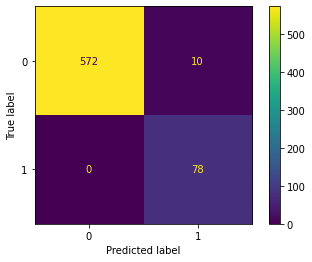

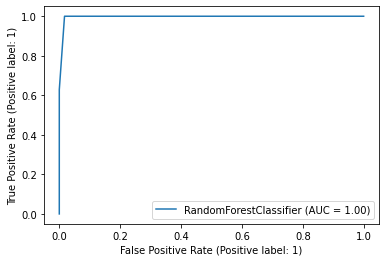

Abstraction level: 1000
abstract states: 36
Concrete states 247411
ratio 0.0001455068691367805
shape of data 36
********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 1.0


--------------------------------------recall---------------------------------
the test recall for the class yes is 1.0
the test recall for the class no is 1.0
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 1.0
the test precision for the class no is 1.0
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        1.00      1.00      1.00       582
         yes       1.00      1.00      1.00        78

    accuracy                           1.00       660
   macro

c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


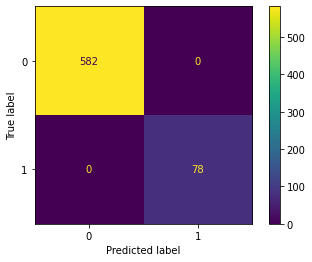

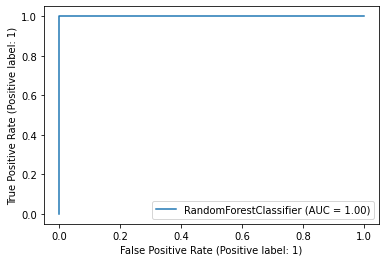

Abstraction level: 500
abstract states: 85
Concrete states 247411
ratio 0.0003435578854618428
shape of data 85
********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 1.0


--------------------------------------recall---------------------------------
the test recall for the class yes is 1.0
the test recall for the class no is 1.0
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 1.0
the test precision for the class no is 1.0
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        1.00      1.00      1.00       582
         yes       1.00      1.00      1.00        78

    accuracy                           1.00       660
   macro 

c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


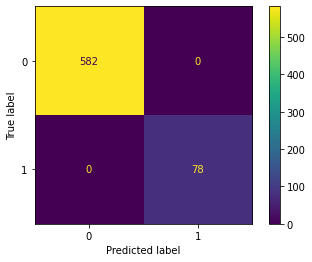

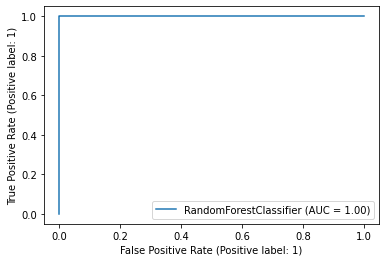

Abstraction level: 100
abstract states: 788
Concrete states 247411
ratio 0.0031849836911050844
shape of data 788
********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 1.0


--------------------------------------recall---------------------------------
the test recall for the class yes is 1.0
the test recall for the class no is 1.0
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 1.0
the test precision for the class no is 1.0
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        1.00      1.00      1.00       582
         yes       1.00      1.00      1.00        78

    accuracy                           1.00       660
   macr

c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


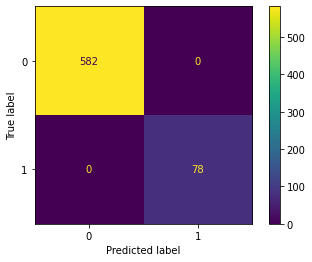

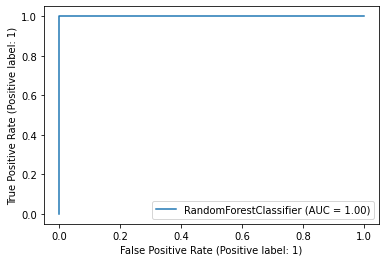

Abstraction level: 50
abstract states: 1638
Concrete states 247411
ratio 0.006620562545723512
shape of data 1638
********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 1.0


--------------------------------------recall---------------------------------
the test recall for the class yes is 1.0
the test recall for the class no is 1.0
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 1.0
the test precision for the class no is 1.0
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        1.00      1.00      1.00       582
         yes       1.00      1.00      1.00        78

    accuracy                           1.00       660
   macr

c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


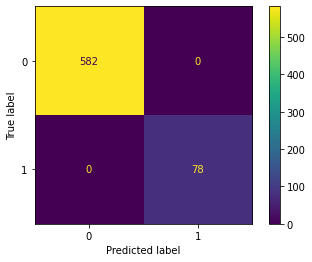

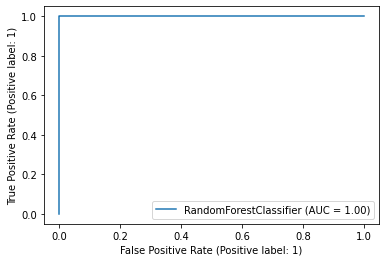

Abstraction level: 10
abstract states: 7090
Concrete states 247411
ratio 0.028656769504993716
shape of data 7090
********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 1.0


--------------------------------------recall---------------------------------
the test recall for the class yes is 1.0
the test recall for the class no is 1.0
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 1.0
the test precision for the class no is 1.0
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        1.00      1.00      1.00       582
         yes       1.00      1.00      1.00        78

    accuracy                           1.00       660
   macr

c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


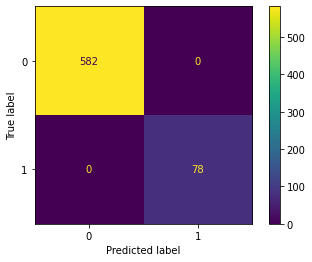

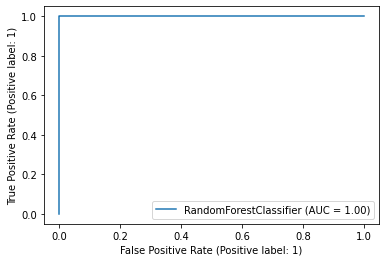

Abstraction level: 5
abstract states: 13208
Concrete states 247411
ratio 0.05338485354329436
shape of data 13208
********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 1.0


--------------------------------------recall---------------------------------
the test recall for the class yes is 1.0
the test recall for the class no is 1.0
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 1.0
the test precision for the class no is 1.0
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        1.00      1.00      1.00       582
         yes       1.00      1.00      1.00        78

    accuracy                           1.00       660
   macr

c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


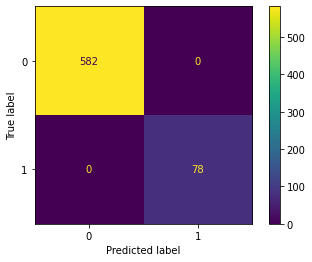

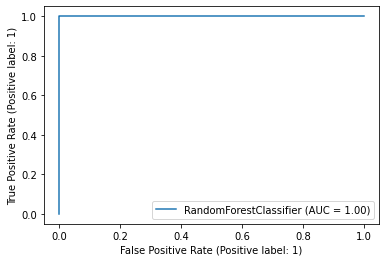

Abstraction level: 1
abstract states: 46560
Concrete states 247411
ratio 0.18818888408356946
shape of data 46560
********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 1.0


--------------------------------------recall---------------------------------
the test recall for the class yes is 1.0
the test recall for the class no is 1.0
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 1.0
the test precision for the class no is 1.0
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        1.00      1.00      1.00       582
         yes       1.00      1.00      1.00        78

    accuracy                           1.00       660
   macr

c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


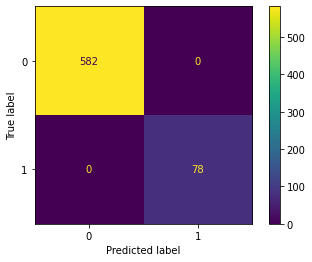

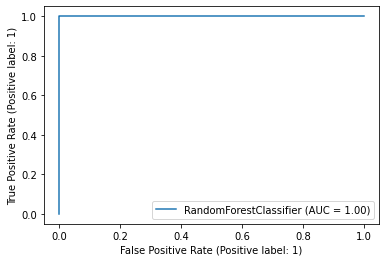

Abstraction level: 0.5
abstract states: 69224
Concrete states 247411
ratio 0.2797935419201248
shape of data 69224
********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 1.0


--------------------------------------recall---------------------------------
the test recall for the class yes is 1.0
the test recall for the class no is 1.0
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 1.0
the test precision for the class no is 1.0
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        1.00      1.00      1.00       582
         yes       1.00      1.00      1.00        78

    accuracy                           1.00       660
   mac

c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


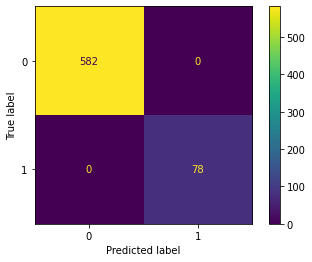

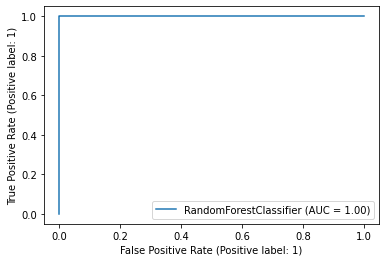

Abstraction level: 0.05
abstract states: 167306
Concrete states 247411
ratio 0.6762270068832833
shape of data 167306
********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.9136363636363637


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.2692307692307692
the test recall for the class no is 1.0
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 1.0
the test precision for the class no is 0.9107981220657277
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        0.91      1.00      0.95       582
         yes       1.00      0.27      0.42        78

    accuracy

c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


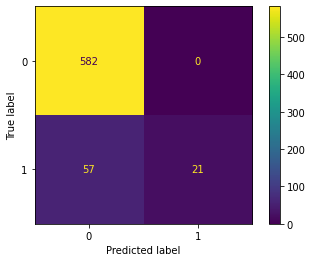

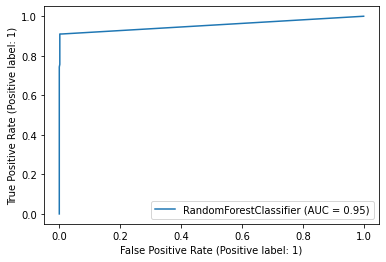

In [8]:
from tqdm import tqdm

d_set=[5000,1000,500,100,50,10,5,1,0.5,0.05]


#load ml training data
with open(f'{Dataset_path}/Random_episodes/FRT_training.pickle', 'rb') as file2:
    final_episodes = pickle.load(file2)

    
for d in d_set:
    print(f"Abstraction level: {d}")
    Read_from_data = False

    if Read_from_data:
        with open(f'{Dataset_path}/Abstraction/Abstraction_data_sampled_200_{d}.pickle', 'rb') as file2:
            unique1 = pickle.load(file2)
            uni1=np.array(unique1)
    if not Read_from_data:
        unique1,uni1 = Abstract_classes(final_episodes,d,model)
        with open(f'{Dataset_path}/Abstraction/Abstraction_data_sampled_200_{d}.pickle', 'wb') as file2:
            pickle.dump(unique1, file2)


    data1_x_b, data1_y_b, data1_y_f_b = ML_first_representation_func_based(d,
                                                                        is_functional_fault,
                                                                        is_reward_fault
                                                                        ,model
                                                                        ,final_episodes
                                                                        ,unique1)

    print("shape of data",len(data1_x_b[0]))
    #########################################################  Train ML - Functional fault predictor #############


    X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(data1_x_b, data1_y_f_b, test_size=0.30, random_state=42)
    RF_FF_1rep = RandomForestClassifier(random_state=0, class_weight='balanced')
    RF_FF_1rep.fit(X_train_f,y_train_f)
    report(RF_FF_1rep,X_train_f,y_train_f,X_test_f,y_test_f)
    #save RF_FF_1rep
    with open(f'{Dataset_path}/ML_models/RF_FF_1rep_{d}.pickle', 'wb') as file2:
        pickle.dump(RF_FF_1rep, file2)

# Analysing more d values 

Abstraction level: 10000
abstract states: 8
Concrete states 247411
ratio 3.233485980817344e-05
shape of data 8
********************** reporting the result of the model **************************
The score for train data is 0.9396103896103896
The score for test data is 0.956060606060606


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.6282051282051282
the test recall for the class no is 1.0
the training recall for the class yes is 0.5373134328358209
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 1.0
the test precision for the class no is 0.9525368248772504
the training precision for the class yes is 1.0
the training precision for the class no is 0.9350558659217877



              precision    recall  f1-score   support

         NO        0.95      1.00      0.98       582
         yes       1.00      

c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


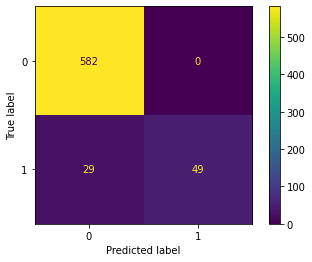

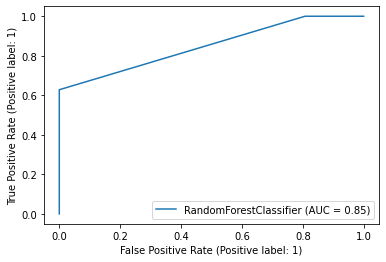

Abstraction level: 8000
abstract states: 8
Concrete states 247411
ratio 3.233485980817344e-05
shape of data 8
********************** reporting the result of the model **************************
The score for train data is 0.9396103896103896
The score for test data is 0.956060606060606


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.6282051282051282
the test recall for the class no is 1.0
the training recall for the class yes is 0.5373134328358209
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 1.0
the test precision for the class no is 0.9525368248772504
the training precision for the class yes is 1.0
the training precision for the class no is 0.9350558659217877



              precision    recall  f1-score   support

         NO        0.95      1.00      0.98       582
         yes       1.00      0

c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


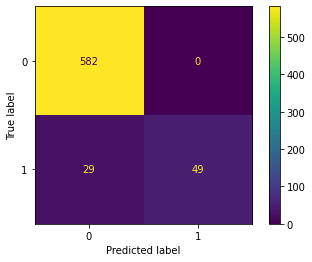

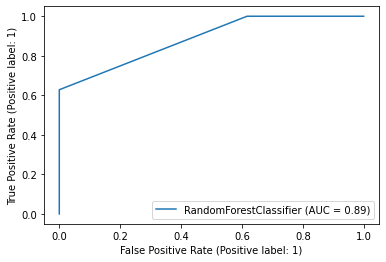

Abstraction level: 7000
abstract states: 8
Concrete states 247411
ratio 3.233485980817344e-05
shape of data 8
********************** reporting the result of the model **************************
The score for train data is 0.8045454545454546
The score for test data is 0.803030303030303


--------------------------------------recall---------------------------------
the test recall for the class yes is 1.0
the test recall for the class no is 0.7766323024054983
the training recall for the class yes is 1.0
the training recall for the class no is 0.7752053771471247


--------------------------------------precision------------------------------
the test precision for the class yes is 0.375
the test precision for the class no is 1.0
the training precision for the class yes is 0.40039840637450197
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        1.00      0.78      0.87       582
         yes       0.38      1.00      0.5

c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


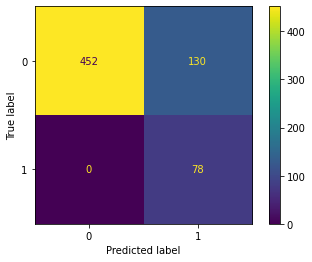

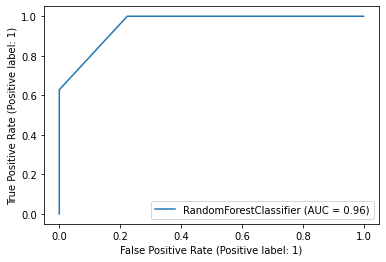

Abstraction level: 6000
abstract states: 9
Concrete states 247411
ratio 3.6376717284195126e-05
shape of data 9
********************** reporting the result of the model **************************
The score for train data is 0.8974025974025974
The score for test data is 0.8924242424242425


--------------------------------------recall---------------------------------
the test recall for the class yes is 1.0
the test recall for the class no is 0.8780068728522337
the training recall for the class yes is 1.0
the training recall for the class no is 0.8820014936519791


--------------------------------------precision------------------------------
the test precision for the class yes is 0.5234899328859061
the test precision for the class no is 1.0
the training precision for the class yes is 0.5598885793871866
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        1.00      0.88      0.94       582
         yes       0.52     

c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


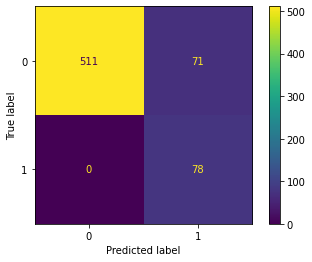

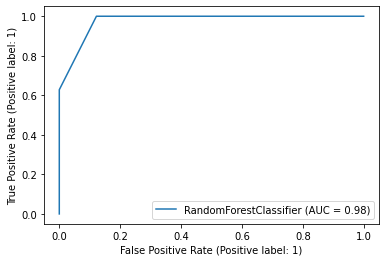

Abstraction level: 4000
abstract states: 10
Concrete states 247411
ratio 4.041857476021681e-05
shape of data 10
********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 1.0


--------------------------------------recall---------------------------------
the test recall for the class yes is 1.0
the test recall for the class no is 1.0
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 1.0
the test precision for the class no is 1.0
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        1.00      1.00      1.00       582
         yes       1.00      1.00      1.00        78

    accuracy                           1.00       660
   macro

c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


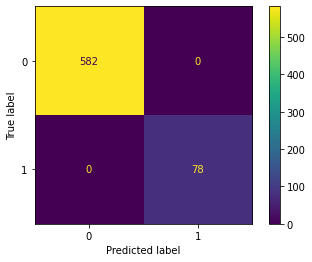

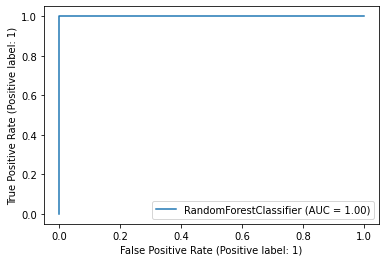

Abstraction level: 3000
abstract states: 13
Concrete states 247411
ratio 5.2544147188281844e-05
shape of data 13
********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 1.0


--------------------------------------recall---------------------------------
the test recall for the class yes is 1.0
the test recall for the class no is 1.0
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 1.0
the test precision for the class no is 1.0
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        1.00      1.00      1.00       582
         yes       1.00      1.00      1.00        78

    accuracy                           1.00       660
   macr

c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


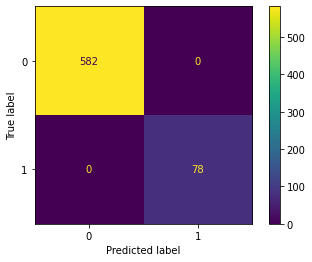

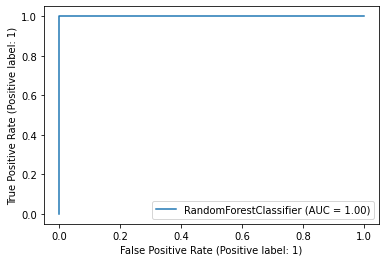

Abstraction level: 2000
abstract states: 16
Concrete states 247411
ratio 6.466971961634689e-05
shape of data 16
********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 1.0


--------------------------------------recall---------------------------------
the test recall for the class yes is 1.0
the test recall for the class no is 1.0
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 1.0
the test precision for the class no is 1.0
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        1.00      1.00      1.00       582
         yes       1.00      1.00      1.00        78

    accuracy                           1.00       660
   macro

c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


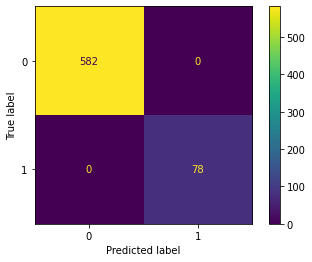

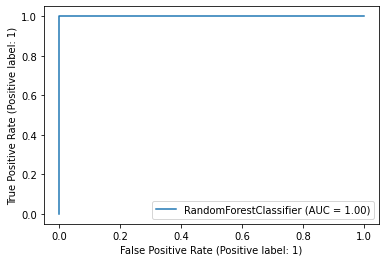

Abstraction level: 0.1
abstract states: 136505
Concrete states 247411
ratio 0.5517337547643395
shape of data 136505
********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.9393939393939394


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.48717948717948717
the test recall for the class no is 1.0
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 1.0
the test precision for the class no is 0.9356913183279743
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        0.94      1.00      0.97       582
         yes       1.00      0.49      0.66        78

    accuracy

c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


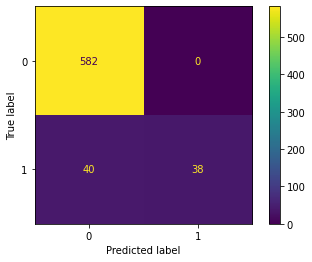

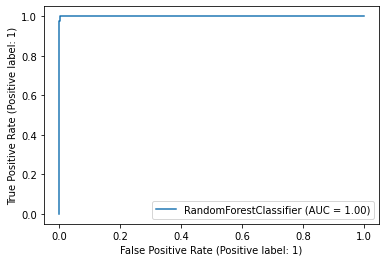

Abstraction level: 0.07
abstract states: 152813
Concrete states 247411
ratio 0.617648366483301
shape of data 152813
********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.9257575757575758


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.3717948717948718
the test recall for the class no is 1.0
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 1.0
the test precision for the class no is 0.9223454833597464
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        0.92      1.00      0.96       582
         yes       1.00      0.37      0.54        78

    accuracy 

c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


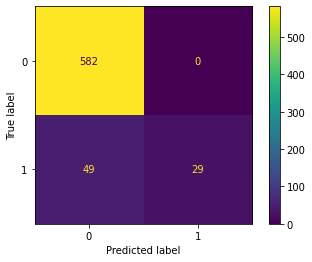

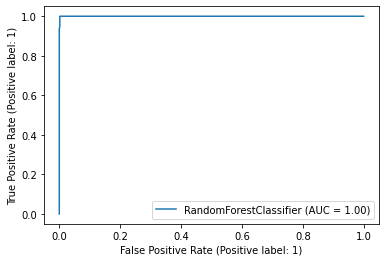

Abstraction level: 0.03
abstract states: 187283
Concrete states 247411
ratio 0.7569711936817684
shape of data 187283
********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.896969696969697


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.1282051282051282
the test recall for the class no is 1.0
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 1.0
the test precision for the class no is 0.8953846153846153
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        0.90      1.00      0.94       582
         yes       1.00      0.13      0.23        78

    accuracy 

c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


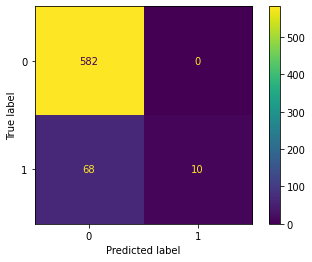

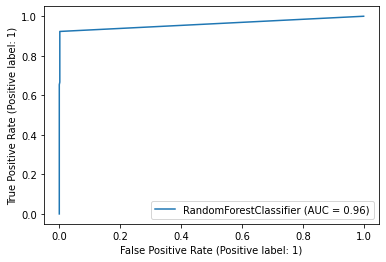

Abstraction level: 0.01
abstract states: 218907
Concrete states 247411
ratio 0.884790894503478
shape of data 218907
********************** reporting the result of the model **************************
The score for train data is 0.9987012987012988
The score for test data is 0.8833333333333333


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.01282051282051282
the test recall for the class no is 1.0
the training recall for the class yes is 0.9900497512437811
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 1.0
the test precision for the class no is 0.8831562974203339
the training precision for the class yes is 1.0
the training precision for the class no is 0.9985085756897838



              precision    recall  f1-score   support

         NO        0.88      1.00      0.94       582
         yes       1.0

c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\Desktop\vs_git\.virtualenvs\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


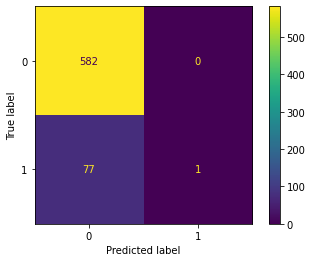

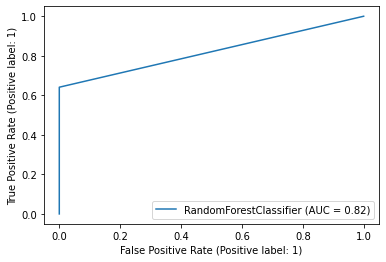

In [7]:
from tqdm import tqdm
# d_set=[0.5,1,5,10,50,100,500]
# d_set=[5000,1000,500,100,50,10,5,1,0.5,0.05]
d_set=[10000,8000,7000,6000,4000,3000,2000,0.1,0.07,0.03,0.01]



#load ml training data
with open(f'{Dataset_path}/Random_episodes/FRT_training.pickle', 'rb') as file2:
    final_episodes = pickle.load(file2)

    
for d in d_set:
    print(f"Abstraction level: {d}")
    Read_from_data = False

    if Read_from_data:
        with open(f'{Dataset_path}/Abstraction/Abstraction_data_sampled_200_{d}.pickle', 'rb') as file2:
            unique1 = pickle.load(file2)
            uni1=np.array(unique1)
    if not Read_from_data:
        unique1,uni1 = Abstract_classes(final_episodes,d,model)
        with open(f'{Dataset_path}/Abstraction/Abstraction_data_sampled_200_{d}.pickle', 'wb') as file2:
            pickle.dump(unique1, file2)


    data1_x_b, data1_y_b, data1_y_f_b = ML_first_representation_func_based(d,
                                                                        is_functional_fault,
                                                                        is_reward_fault
                                                                        ,model
                                                                        ,final_episodes
                                                                        ,unique1)

    print("shape of data",len(data1_x_b[0]))
    #########################################################  Train ML - Functional fault predictor #############


    X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(data1_x_b, data1_y_f_b, test_size=0.30, random_state=42)
    RF_FF_1rep = RandomForestClassifier(random_state=0, class_weight='balanced')
    RF_FF_1rep.fit(X_train_f,y_train_f)
    report(RF_FF_1rep,X_train_f,y_train_f,X_test_f,y_test_f)
    #save RF_FF_1rep
    with open(f'{Dataset_path}/ML_models/RF_FF_1rep_{d}.pickle', 'wb') as file2:
        pickle.dump(RF_FF_1rep, file2)

# plot risks

In [ ]:
# data of abstract classes
from tqdm import tqdm

d_set=[10000,8000,7000,6000,4000,3000,2000,0.1,0.07,0.03,0.01]

d_set=[5] #select desired abatraction levels to explore

#load ml training data
with open(f'{Dataset_path}/Random_episodes/FRT_training.pickle', 'rb') as file2:
    final_episodes = pickle.load(file2)

    
for d in d_set:
    print(f"Abstraction level: {d}")
    Read_from_data = False

    if Read_from_data:
        with open(f'{Dataset_path}/Abstraction/Abstraction_data_sampled_200_{d}.pickle', 'rb') as file2:
            unique1 = pickle.load(file2)
            uni1=np.array(unique1)
    if not Read_from_data:
        unique1,uni1 = Abstract_classes(final_episodes,d,model)
        with open(f'{Dataset_path}/Abstraction/Abstraction_data_sampled_200_{d}.pickle', 'wb') as file2:
            pickle.dump(unique1, file2)



    # #########################################################  Load ML - Functional fault predictor #############


    with open(f'{Dataset_path}/ML_models/RF_FF_1rep_{d}.pickle', 'rb') as file2:
        RF_FF_1rep = pickle.load(file2)

    #read FRT and FRTS from pickle
    with open(f'{Dataset_path}/Random_episodes/FRT.pickle', 'rb') as file2:
        FRT = pickle.load(file2)
    
    par = [d,unique1,model,RF_FF_1rep]

    #########################################################  Plot Risk and Position #############
    newpath = f'Plots/Abs_{d}'
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    Num_plot = 200 #number of episodes to plot
    if len(FRT)<Num_plot:
        print("number of available episodes is less than {Num_plot}}")
        Num_plot = len(FRT)
    print("Number of episodes to plot:",Num_plot)        
    for i in tqdm(range(0,Num_plot,10), desc="Plotting", total=Num_plot//10):
        Plot_all(FRT[i:i+10],par,save=True,show=False,data_chunk=i,path=newpath)
    

# Confidence Intervals

In [9]:
import scipy

def translate_episode_steps(episode,RL_model,translator,d,abs_classes):
    translated_episode = []
    for i in range(len(episode)-1):
        translated_episode.append(translator(episode[:i],RL_model,d,abs_classes))
    return translated_episode

def translate_multiple_episodes_steps(episodes,RL_model,translator,d,abs_classes):
    translated_episodes = []
    for episode in episodes:
        translated_buffer = []
        for i in range(len(episode)-1):
            translated_buffer.append(translator(episode[:i],RL_model,d,abs_classes))
        translated_episodes.append(translated_buffer)
    return translated_episodes



def Forest_CI_multiple(translated_episodes,HD_model,chunk,abs_d,path = 'C:/Users/Student/Desktop/vs_git/HazardDetection/Plots/CI'):
    '''
    size of translated_episodes is limited by the number of colors available for one plot
    '''
    plt.figure(figsize=(20, 12))
    results_Arr=[]
    r_arr=[]
    E=0
    colors = ['red','blue','green','yellow','black','purple','orange','pink','brown','grey','cyan','magenta','lime','olive','teal','navy','maroon','violet','turquoise','salmon','gold','coral','indigo','crimson','azure','beige','chocolate','lavender','plum','orchid','tan','khaki','wheat','silver','sienna','peru','peachpuff','papayawhip','mistyrose','moccasin','lemonchiffon','lawngreen','lightgreen','limegreen']
    for translated_episode , plt_color in zip(translated_episodes,colors[:len(translated_episodes)]):
        E+=1
        num_time_steps = len(translated_episode) # Number of time steps
        num_trees = HD_model.n_estimators
        predictions = np.zeros((num_time_steps, num_trees))
        for i, tree in enumerate(HD_model.estimators_):
            for j in range(len(translated_episode)):
                Risk = tree.predict_proba(translated_episode[j])[0][1]
                predictions[j, i] = Risk
        # Calculate the mean prediction for each time step
        mean_predictions = np.mean(predictions, axis=1)

        # Calculate the standard deviation for each time step
        std_predictions = np.std(predictions, axis=1)

        # Calculate the lower and upper bounds for the confidence intervals
        confidence_level = 0.95 # Change as needed
        z_score = scipy.stats.norm.ppf((1 + confidence_level) / 2)
        lower_bounds = mean_predictions - z_score * std_predictions / np.sqrt(num_trees)
        upper_bounds = mean_predictions + z_score * std_predictions / np.sqrt(num_trees)
        difference = upper_bounds - lower_bounds
        # Store the results in a dataframe
        results = pd.DataFrame({
            'Mean prediction': mean_predictions,
            'Lower bound': lower_bounds,
            'Upper bound': upper_bounds
        })
        # Save the results to a file
        results_Arr.append(results)
        r_arr.append([mean_predictions, lower_bounds, upper_bounds,difference])
        plt.fill_between(range(num_time_steps), lower_bounds, upper_bounds, color=plt_color, alpha=0.2)
        plt.plot(mean_predictions, color=plt_color, label=f'Episode {E}')

        # Add labels and title to the plot
        plt.xlabel('Time step')
        plt.ylabel('Prediction')
        plt.title('Confidence Intervals of Random Forest Predictions')
    # results_arr.append(r_arr)
    # Save the plot as a file
    current_time = datetime.now()
    ID = current_time.strftime("%Y%m%d%H%M%S")
    # if save:
    #     fig.savefig(f'{path}/RPV_C{data_chunk}_{ID}.png')
    # plt.savefig(f'C:/Users/Student/Desktop/vs_git/HazardDetection/Plots/CI/abs_{d}/confidence_intervals_{chunk}_{ID}.png', bbox_inches='tight')
    plt.legend()
    plt.savefig(f'{path}/confidence_intervals_{chunk}_{ID}.png', bbox_inches='tight')
    plt.close()
    # np.array(results_Arr).to_csv('confidence_intervals.csv', index=False)
    # save results_arr to pickle file
    pickle_path = f'Data/CI/Abs_{abs_d}'
    if not os.path.exists(pickle_path):
        os.makedirs(pickle_path)
    with open(f'{pickle_path}/results_arr_{chunk}.pkl', 'wb') as f:
        pickle.dump(r_arr, f)




    


# CI plots

In [14]:
######################################################### Read abstract classes #############
# data of abstract classes
from tqdm import tqdm
# d_set=[0.5,1,5,10,50,100,500]
# d_set=[10000,8000,7000,6000,4000,3000,2000,0.1,0.07,0.03,0.01]

d_set=[500,100,50,10,5,1,0.5]

# d_set=[500]

with open(f'{Dataset_path}/Random_episodes/FRT_training.pickle', 'rb') as file2:
    final_episodes = pickle.load(file2)

    
for d in d_set:
    print(f"Abstraction level: {d}")
    Read_from_data = False

    if Read_from_data:
        with open(f'{Dataset_path}/Abstraction/Abstraction_data_sampled_200_{d}.pickle', 'rb') as file2:
            unique1 = pickle.load(file2)
            uni1=np.array(unique1)
    if not Read_from_data:
        unique1,uni1 = Abstract_classes(final_episodes,d,model)
        with open(f'{Dataset_path}/Abstraction/Abstraction_data_sampled_200_{d}.pickle', 'wb') as file2:
            pickle.dump(unique1, file2)



    # #########################################################  Load ML - Functional fault predictor #############


    with open(f'{Dataset_path}/ML_models/RF_FF_1rep_{d}.pickle', 'rb') as file2:
        RF_FF_1rep = pickle.load(file2)

    #read FRT and FRTS from pickle
    with open(f'{Dataset_path}/Random_episodes/FRT.pickle', 'rb') as file2:
        FRT = pickle.load(file2)
    
    # par = [d,unique1,model,RF_FF_1rep]

    #########################################################  Plot Risk and Position #############
    newpath = f'Plots/Abs_{d}'
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    Num_plot = 200 #number of episodes to plot
    if len(FRT)<Num_plot:
        print("number of available episodes is less than {Num_plot}}")
        Num_plot = len(FRT)
    print("Number of episodes to plot:",Num_plot)        
    for i in tqdm(range(0,Num_plot,10), desc="Plotting", total=Num_plot//10):
        Forest_CI_multiple(translate_multiple_episodes_steps(FRT[i:i+10],model,translator,d,unique1),RF_FF_1rep,i,d,path=newpath)
    



Abstraction level: 500


Plotting: 100%|██████████| 50/50 [24:02<00:00, 28.85s/it]


Abstraction level: 100


Plotting: 100%|██████████| 50/50 [25:03<00:00, 30.07s/it]


Abstraction level: 50


Plotting: 100%|██████████| 50/50 [26:43<00:00, 32.07s/it]


Abstraction level: 10


Plotting: 100%|██████████| 50/50 [37:09<00:00, 44.58s/it]


Abstraction level: 5


Plotting: 100%|██████████| 50/50 [17:55:15<00:00, 1290.31s/it]     


Abstraction level: 1


Plotting: 100%|██████████| 50/50 [2:30:23<00:00, 180.47s/it]  


Abstraction level: 0.5


Plotting: 100%|██████████| 50/50 [2:32:10<00:00, 182.62s/it]  


# accuracy 

In [24]:
def ACCu(translated_episodes,HD_model,chunk,abs_d,path='Data/Pred'):
    '''
    size of translated_episodes is limited by the number of colors available for one plot
    '''
    # plt.figure(figsize=(20, 12))
    results_Arr=[]
    r_arr=[]
    E=0
    RF_pred=[]
    # translated_episodes = translate_multiple_episodes_steps(episode,RL_model,translator,d,unique1)
    # colors = ['red','blue','green','yellow','black','purple','orange','pink','brown','grey','cyan','magenta','lime','olive'\
    # ,'teal','navy','maroon','violet','turquoise','salmon','gold','coral','indigo','crimson','azure','beige','chocolate',\
    # 'lavender','plum','orchid','tan','khaki','wheat','silver','sienna','peru','peachpuff','papayawhip','mistyrose','moccasin','lemonchiffon','lawngreen','lightgreen','limegreen']
    for k, translated_episode in enumerate(translated_episodes):
        RF_pred_E=[]
        E+=1
        num_time_steps = len(translated_episode) # Number of time steps
        num_trees = HD_model.n_estimators
        predictions = np.zeros((num_time_steps, num_trees))
        for j in tqdm(range(len(translated_episode)),desc=f'extracting risk for episode {k}'):
            RF_pred_E.append(HD_model.predict_proba(translated_episode[j])[0][1])
            for i, tree in enumerate(HD_model.estimators_):
                Risk = tree.predict_proba(translated_episode[j])[0][1]
                predictions[j, i] = Risk
        # Calculate the mean prediction for each time step
        mean_predictions = np.mean(predictions, axis=1)
            
        # Calculate the standard deviation for each time step
        std_predictions = np.std(predictions, axis=1)

        # Calculate the lower and upper bounds for the confidence intervals
        confidence_level = 0.95 # Change as needed
        z_score = scipy.stats.norm.ppf((1 + confidence_level) / 2)
        lower_bounds = mean_predictions - z_score * std_predictions / np.sqrt(num_trees)
        upper_bounds = mean_predictions + z_score * std_predictions / np.sqrt(num_trees)
        difference = upper_bounds - lower_bounds
        # Store the results in a dataframe
        results = pd.DataFrame({
            'Mean prediction': mean_predictions,
            'Lower bound': lower_bounds,
            'Upper bound': upper_bounds
        })
        # Save the results to a file
        results_Arr.append(results)
        r_arr.append([mean_predictions, lower_bounds, upper_bounds,difference])

        RF_pred.append(RF_pred_E)

    return RF_pred



def ACCURACY(translated_episodes,HD_model,chunk,abs_d,path='Data/Pred'):
    '''
    size of translated_episodes is limited by the number of colors available for one plot
    '''
    # plt.figure(figsize=(20, 12))
    results_Arr=[]
    r_arr=[]
    E=0
    RF_pred=[]
    # translated_episodes = translate_multiple_episodes_steps(episode,RL_model,translator,d,unique1)
    # colors = ['red','blue','green','yellow','black','purple','orange','pink','brown','grey','cyan','magenta','lime','olive'\
    # ,'teal','navy','maroon','violet','turquoise','salmon','gold','coral','indigo','crimson','azure','beige','chocolate',\
    # 'lavender','plum','orchid','tan','khaki','wheat','silver','sienna','peru','peachpuff','papayawhip','mistyrose','moccasin','lemonchiffon','lawngreen','lightgreen','limegreen']
    for translated_episode in tqdm(translated_episodes, desc=f'extracting risk for episodes'):
        RF_pred_E=[]
        E+=1
        num_time_steps = len(translated_episode) # Number of time steps
        num_trees = HD_model.n_estimators
        predictions = np.zeros((num_time_steps, num_trees))
        for j in range(len(translated_episode)):
            RF_pred_E.append(HD_model.predict_proba(translated_episode[j])[0][1])
            for i, tree in enumerate(HD_model.estimators_):
                Risk = tree.predict_proba(translated_episode[j])[0][1]
                predictions[j, i] = Risk
        # Calculate the mean prediction for each time step
        mean_predictions = np.mean(predictions, axis=1)
            
        # Calculate the standard deviation for each time step
        std_predictions = np.std(predictions, axis=1)

        # Calculate the lower and upper bounds for the confidence intervals
        confidence_level = 0.95 # Change as needed
        z_score = scipy.stats.norm.ppf((1 + confidence_level) / 2)
        lower_bounds = mean_predictions - z_score * std_predictions / np.sqrt(num_trees)
        upper_bounds = mean_predictions + z_score * std_predictions / np.sqrt(num_trees)
        difference = upper_bounds - lower_bounds
        # Store the results in a dataframe
        results = pd.DataFrame({
            'Mean prediction': mean_predictions,
            'Lower bound': lower_bounds,
            'Upper bound': upper_bounds
        })
        # Save the results to a file
        results_Arr.append(results)
        r_arr.append([mean_predictions, lower_bounds, upper_bounds,difference])
        RF_pred.append(RF_pred_E)
    return RF_pred

def extract_weighted_performance(Pred, FRT, T):
    labels = []
    for episode in FRT:
        if is_functional_fault(episode):
            labels.append([1.0 for i in range(len(episode)-1)])
        else:
            labels.append([0.0 for i in range(len(episode)-1)])
    
    accuracy = []
    accuracy_w = []
    precision = []
    recall = []
    f1 = []
    max_len = max([len(i) for i in Pred])
    for i in range(max_len):
        pred_interval = [0 if pred[i]<=T else 1 for pred in Pred if len(pred)>i]
        labels_interval = [label[i] for label in labels if len(label)>i]
        accuracy.append(accuracy_score(labels_interval,pred_interval))
        accuracy_w.append(balanced_accuracy_score(labels_interval, pred_interval))
        precision.append(precision_score(labels_interval, pred_interval, average='weighted'))
        recall.append(recall_score(labels_interval, pred_interval, average='weighted'))
    #     f1.append(f1_score(labels_interval, pred_interval, average='weighted'))
    # micro_f1 = f1_score(labels_interval, pred_interval, average='micro')
    # macro_f1 = f1_score(labels_interval, pred_interval, average='macro')
    return [accuracy,accuracy_w, precision, recall]

def plot_and_save_metrics(metrics_w, save_path):
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    accuracy,accuracy_w, precision, recall = metrics_w
    axs[0, 0].plot(accuracy)
    axs[0, 0].set_title("Accuracy")
    axs[0, 1].plot(accuracy_w)
    axs[0, 1].set_title("Balanced Accuracy")
    axs[1, 0].plot(precision)
    axs[1, 0].set_title("Precision")
    axs[1, 1].plot(recall)
    axs[1, 1].set_title("Recall")

    plt.suptitle("Metrics Plot")
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.savefig(save_path)
    plt.close()

import scipy

def translate_episode_steps(episode,RL_model,translator,d,abs_classes):
    translated_episode = []
    for i in range(len(episode)-1):
        translated_episode.append(translator(episode[:i],RL_model,d,abs_classes))
    return translated_episode

def translate_multiple_episodes_steps(episodes,RL_model,translator,d,abs_classes):
    translated_episodes = []
    for n, episode in enumerate(episodes):
        translated_buffer = []
        for i in tqdm(range(len(episode)-1),desc=f'translating episode {n}'):
            translated_buffer.append(translator(episode[:i],RL_model,d,abs_classes))
        translated_episodes.append(translated_buffer)
    return translated_episodes


def translate_multiple_episodes_steps_tqdm(episodes,RL_model,translator,d,abs_classes):
    translated_episodes = []
    for episode in tqdm(episodes,desc=f'translating episodes'):
        translated_buffer = []
        for i in range(len(episode)-1):
            translated_buffer.append(translator(episode[:i],RL_model,d,abs_classes))
        translated_episodes.append(translated_buffer)
    return translated_episodes


def Forest_CI_multiple(translated_episodes,HD_model,chunk,abs_d,path = 'Plots/CI'):
    '''
    size of translated_episodes is limited by the number of colors available for one plot
    '''
    plt.figure(figsize=(20, 12))
    results_Arr=[]
    r_arr=[]
    E=0
    colors = ['red','blue','green','yellow','black','purple','orange','pink','brown','grey','cyan','magenta','lime','olive','teal','navy','maroon','violet','turquoise','salmon','gold','coral','indigo','crimson','azure','beige','chocolate','lavender','plum','orchid','tan','khaki','wheat','silver','sienna','peru','peachpuff','papayawhip','mistyrose','moccasin','lemonchiffon','lawngreen','lightgreen','limegreen']
    for translated_episode , plt_color in zip(translated_episodes,colors[:len(translated_episodes)]):
        E+=1
        num_time_steps = len(translated_episode) # Number of time steps
        num_trees = HD_model.n_estimators
        predictions = np.zeros((num_time_steps, num_trees))
        for i, tree in enumerate(HD_model.estimators_):
            for j in range(len(translated_episode)):
                Risk = tree.predict_proba(translated_episode[j])[0][1]
                predictions[j, i] = Risk
        # Calculate the mean prediction for each time step
        mean_predictions = np.mean(predictions, axis=1)

        # Calculate the standard deviation for each time step
        std_predictions = np.std(predictions, axis=1)

        # Calculate the lower and upper bounds for the confidence intervals
        confidence_level = 0.95 # Change as needed
        z_score = scipy.stats.norm.ppf((1 + confidence_level) / 2)
        lower_bounds = mean_predictions - z_score * std_predictions / np.sqrt(num_trees)
        upper_bounds = mean_predictions + z_score * std_predictions / np.sqrt(num_trees)
        difference = upper_bounds - lower_bounds
        # Store the results in a dataframe
        results = pd.DataFrame({
            'Mean prediction': mean_predictions,
            'Lower bound': lower_bounds,
            'Upper bound': upper_bounds
        })
        # Save the results to a file
        results_Arr.append(results)
        r_arr.append([mean_predictions, lower_bounds, upper_bounds,difference])
        plt.fill_between(range(num_time_steps), lower_bounds, upper_bounds, color=plt_color, alpha=0.2)
        plt.plot(mean_predictions, color=plt_color, label=f'Episode {E}')

        # Add labels and title to the plot
        plt.xlabel('Time step')
        plt.ylabel('Prediction')
        plt.title('Confidence Intervals of Random Forest Predictions')
    # results_arr.append(r_arr)
    # Save the plot as a file
    current_time = datetime.now()
    ID = current_time.strftime("%Y%m%d%H%M%S")
    # if save:
    #     fig.savefig(f'{path}/RPV_C{data_chunk}_{ID}.png')
    # plt.savefig(f'C:/Users/Student/Desktop/vs_git/HazardDetection/Plots/CI/abs_{d}/confidence_intervals_{chunk}_{ID}.png', bbox_inches='tight')
    plt.legend()
    plt.savefig(f'{path}/confidence_intervals_{chunk}_{ID}.png', bbox_inches='tight')
    # np.array(results_Arr).to_csv('confidence_intervals.csv', index=False)
    # save results_arr to pickle file
    pickle_path = f'CI/Abs_{abs_d}'
    if not os.path.exists(pickle_path):
        os.makedirs(pickle_path)
    with open(f'{pickle_path}/results_arr_{chunk}.pkl', 'wb') as f:
        pickle.dump(r_arr, f)


## generate accuracy data and plot metrics

In [ ]:
d_set=[500,100,50,10,5,1]
from tqdm import tqdm
# d_set=[0.5]

#read FRT and FRTS from pickle
with open(f'{Dataset_path}/Random_episodes/FRT.pickle', 'rb') as file2:
    FRT = pickle.load(file2)
with open(f'{Dataset_path}Random_episodes/FRTS.pickle', 'rb') as file2:
    FRTS = pickle.load(file2)

for d in d_set:
    print('\n Abstraction level: ',d,'\n\n')

    Read_from_data = True
    if Read_from_data:
        with open(f'{Dataset_path}/Abstraction/Abstraction_data_sampled_200_{d}.pickle', 'rb') as file2:
            unique1 = pickle.load(file2)
        uni1=np.array(unique1)
    if not Read_from_data:
        unique1,uni1 = Abstract_classes(final_episodes,d,model)

    #read model from pickle
    with open(f'{Dataset_path}/ML_models/RF_FF_1rep_{d}.pickle', 'rb') as file2:
        RF_FF_1rep = pickle.load(file2)

    #########################################################  Plot Risk and Position #############
    newpath = f'Data/Episodes/Abs_{d}'
    if not os.path.exists(newpath):
        os.makedirs(newpath)

    chunk_size = 200
    start = 0
    end = chunk_size
    while start < len(FRT):
        episode_chunk = translate_multiple_episodes_steps_tqdm(FRT[start:end], model, translator, d, unique1)
        with open(f'{newpath}/episode_chunk_{start}_{end}.pickle', 'wb') as file2:
            pickle.dump(episode_chunk, file2)
        del episode_chunk
        start += chunk_size
        end += chunk_size
        if end > len(FRT):
            end = len(FRT)
    
    
    Pred = []
    chunk_size = 200
    start = 0
    end = chunk_size
    while start < len(FRT):
        #read episodes from pickle
        with open(f'{newpath}/episode_chunk_{start}_{end}.pickle', 'rb') as file2:
            episode_chunk = pickle.load(file2)
        Pred += ACCURACY(episode_chunk,RF_FF_1rep,55,abs_d=d,path=newpath)
        del episode_chunk
        start += chunk_size
        end += chunk_size
        if end > len(FRT):
            end = len(FRT)

    met = extract_weighted_performance(Pred, FRT, 0.5)
    #plot metrics and save them
    plot_and_save_metrics(met, f'{newpath}/metrics.png')